In this Python notebook, I describe the details associated with the computational experiments in the paper Aggregating Heterogeneous-Agent Models with Permanent Income Shocks. The source code for the underlying code is provided in the file code_aha.py. The computations are implemented with just-in-time compilation through [the Numba package](https://numba.pydata.org/). For an introduction to Python for economics (or vice versa, an introduction to quantitative economics for Pythonistas), see [QuantEcon](https://quantecon.org/).

First we import the code from code_aha as well as some math and plotting capabilities from numpy and matplotlib. We also import time because you never want to run out of time...

In [1]:
from code_aha import *
import numpy as np
from numpy.polynomial.hermite import hermgauss
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
import seaborn as sns
sns.set_theme()
import time

# Calibration and discretization of the model.

__Discretized state space:__
Next, we describe the discretized grids used in the computational experiments. The grid for cash on hand consists of 300 grid points from 0.1 to 400 and the grid for end-of-period savings consists of 300 grid points from 0 to 400. The grid is finer closer to the borrowing constraint.

The method introduced in the paper, employing the permanent-income-neutral measure, permits computing model aggregates without keeping track of the permanent-income dimension. However, for comparison purposes we will also compute model aggregates without the permanent-income-neutral measure. Therefore, I introduce an equispaced grid in log permanent income from -10 to 10 with 31 grid points.

In [2]:
convexity = 2.0

mgrid = np.linspace(0.10**(1/convexity), 400**(1/convexity), 300)**convexity
dmgrid = np.hstack([mgrid[1:]-mgrid[:-1], [mgrid[-1]-mgrid[-2]]])
bgrid = np.hstack([[0.0], (np.linspace(0.10**(1/convexity), 400**(1/convexity), 299))**convexity])

zgrid = np.linspace(-10, 10, 31)

__Discretized shock distribution:__ For both the permanent income shocks $\eta$ and the transitory income shocks $\epsilon$, I use Gauss-Hermite quadrature with 5 points to describe the shock distributions. The variance of the log of the transitory shock is $0.01\times 4$ and the variance of the log of the permanent income shock is $0.01\times 4/11$, following [Carroll, Slacalek, Tokuoka, and White (QE, 2017)](https://doi.org/10.3982/QE694). The shocks processes are adjusted to ensure that $E[\eta]=E[\epsilon]=1$.

In [3]:
sigma_epsilon = np.sqrt(0.01*4)
sigma_eta = np.sqrt(0.01*4/11)

Nshock = 5
val, prob = hermgauss(Nshock) 
val = np.sqrt(2)*val
prob = prob/np.sqrt(np.pi)
Nepsilon = Nshock
Neta = Nshock

epsilon_prob_temp = prob
epsilon_val_temp = np.exp(val*sigma_epsilon)
epsilon_val_temp = epsilon_val_temp/np.sum(epsilon_prob_temp*epsilon_val_temp)

epsilon_prob = epsilon_prob_temp
epsilon_val = epsilon_val_temp

eta_prob_temp = prob
eta_val_temp = np.exp(val*sigma_eta)/np.sum(eta_prob_temp*np.exp(val*sigma_eta))    

eta_prob = eta_prob_temp
eta_val = eta_val_temp  

Following [Carroll, Slacalek, Tokuoka, and White (QE, 2017)](https://doi.org/10.3982/QE694), household preferences are described by a discount rate $\beta=0.99$ and a risk aversion $\sigma=1.0$.

Finally, to maintain a stationary income distribution, households die in a perpetual-youth fashion at rate $0.00625$, yielding an average working life of 40 years (again, following [Carroll, Slacalek, Tokuoka, and White (QE, 2017)](https://doi.org/10.3982/QE694)). Note that, with the permanent-income-neutral measure, it is not _necessary_ to have a stationary income distribution in order to compute model aggregates, however since I aim to compare with not using the permanent-income-neutral measure, I need a non-degenerate income distribution.

We take all these parameters and save them as a problem_parameters object.

In [4]:
β = 0.99
σ = 1.0

death_prob = 0.00625 

params = problem_parameters(β, σ, mgrid, bgrid, zgrid,
                   Nepsilon, epsilon_val, epsilon_prob,
                   Neta, eta_val, eta_prob, death_prob)

# Optimal consumption behavior

The household problem (on recursive form) is

$$ V(M, Z) = \max_{C} u(C) + \beta E V(M', Z')$$

subject to:

(i) the budget constraint,
$$ B + C = M,$$
(ii) a borrowing constrint,
$$ B\ge 0, $$
(iii) the definition of cash on hand in the next period, $M'$, as savings from the current period and next-period income,
$$ M' = RB + Y' $$
and (iv) the income process
$$ Y' = wZ'\epsilon', $$
$$ Z' = \eta' Z.$$
Finally, $\epsilon'\sim F_{\epsilon}$ and $\eta'\sim F_{\eta}$ are i.i.d. over time.

As is well-known, if $u(\cdot)$ is CRRA with risk aversion $\gamma$, then $V$ can be written on the form $V(A,Z) = v(A/Z)Z^{1-\gamma}$. Denoting $a=A/Z$, $b=B/Z$, etc., we arrive at the normalized household problem.


## Normalized household problem

$$ v(m) = \max_{c} \frac{c^{1-\gamma}}{1-\gamma} + \beta E\left[(\eta')^{1-\gamma} v(m')\right]$$

subject to
$$ m' = R\frac{m-c}{\eta'} + w\epsilon', $$
$$ c \le m, $$
and the shock distributions $\epsilon'\sim F_{\epsilon}$ and $\eta'\sim F_{\eta}$.


For a given wage and interest rate, the household problem is solved with a combination of the endogenous-grid method ([Carroll 2006](https://doi.org/10.1016/j.econlet.2005.09.013)) and a matrix implementation of Howard's improvement algorithm (see p. 18 of [Moritz Kuhn's notes](https://www.wiwi.uni-bonn.de/kuhn/notes/DPNotes.pdf), thanks to Pontus Rendahl for teaching me this "trick"). Below, the optimal consumption function is computed given the wage and price of a bond (as well as an initial guess for the value function, I choose the flow utility of consuming all the cash on hand as the initial guess).

# Computing the stationary permanent-income-weighted distribution

The function ```compute_cash_on_hand_distribution``` computes the stationary permanent-income-weighted distribution using the method from the paper. First, the code creates a discretized transition matrix, then the stationary distribution is computed as the eigenvector associated with eigenvalue 1. The source code is here:

```python
def compute_cash_on_hand_distribution(consumption_function, params, 
                                      R, wage, which = 'Marginal'):
    
    if which == 'Marginal':
        weighting_scheme = 'None'
    if which == 'Permanent Income Weighted':
        weighting_scheme = 'Aggregate'
        
    #Write down discretized transition matrix:
    transition_matrix_aggregate \
        = create_transition_matrix(consumption_function, weighting_scheme,
                                   params, R, wage)

    #Use a scipy routine to compute the eigenvector associated with 
    #eigenvalue 1, i.e., the stationary distribution.
    eigv, stationary_distribution = \
        eigs(transition_matrix_aggregate.transpose(), k = 1, sigma = 1.0)
        
    #The eigenvector that the scipy routine returns should be 
    #normalized to sum to 1
    stationary_distribution = stationary_distribution.real.flatten()\
                              /np.sum(stationary_distribution.real)
    
    return stationary_distribution
```

The function ```transition_matrix_aggregate``` takes as input the previously computed consumption function, the parameters of the problem and the prices (the wage and the interest rate). Furthermore, it takes as an input whether one should compute permanent-income-weighted dynamics or not.

Inside ```transition_matrix_aggregate```, the only difference between the two options are the following lines.
```python
if weighting_scheme == 'None':
    weight = prob
if weighting_scheme == 'Aggregate':
    weight = params.eta_val[eta_i]*prob
```

# Solving an Aiyagari model using the permanent-income-neutral measure

We now take our aggregation method and use it to solve an Aiyagari model. The central function is ```compute_implied_savings``` that takes a level of the capital stock and return the implied steady state level of savings. The equilibrium is obtained when the capital stock equals the savings.

The code for the function is below. It computes the prices implied by the capital stock, computes the consumption function, computs the permanent-income-weighted distribution and then finally backs out the savings from the permanent-income-weighted distribution.

```python
def compute_implied_savings(Kguess, initial_v, params, alpha, delta):

    R = (alpha*Kguess**(alpha-1)+(1-delta))/(1-params.death_prob)
    wage = (1-alpha)*Kguess**alpha
    inner_start = time.time()
    consumption_function, v = \
        compute_optimal_consumption_function(initial_v, R, wage, params)
    inner_mid_point = time.time()
    piw_distribution = \
        compute_cash_on_hand_distribution(consumption_function, params, 
                                          R, wage, 
                                          which = 'Permanent Income Weighted')
    inner_end = time.time()
    
    b_end_of_period = params.mgrid-consumption_function
    K = np.sum(b_end_of_period*piw_distribution)
    print("Difference:", Kguess-K)
    print("K:", K)
    print("K/Y:", K**(1-alpha))
    print("Consumption computation time =", inner_mid_point - inner_start)
    print("Distribution computation time = ", inner_end - inner_mid_point)
    print("*"*50)
    return K, v, piw_distribution
```

Since we are interested in computational performance, it also prints how long time it takes to compute optimal consumption and the permanent-income-weighted distribution.

I take this function and put it inside a simple ```while``` loop that implements Broyden's method.

The capital share $\alpha$ for the production function $Y = K^\alpha L^{1-\alpha}$ and the depreciation rate $\delta$ are (again) taken from [Carroll, Slacalek, Tokuoka, and White (QE, 2017)](https://doi.org/10.3982/QE694).

In [13]:
start = time.time()

initial_v = u(mgrid, params.σ)

#Production is Cobb Douglas Y = K^α*L^(1-α) with capital share α.
α = 0.36
#Capital depreciates at rate δ
δ = 0.025

Kold = 60.0
K = 50.0
v = initial_v

Kold_implied, v, piw_distribution = \
    compute_implied_savings(Kold, initial_v, params, α, δ)
initial_v = v
K_implied, v, piw_distribution = \
    compute_implied_savings(K, initial_v, params, α, δ)

while np.abs(K_implied-K) > 1e-10:
    slope = (np.log(K_implied)-np.log(K)-\
             np.log(Kold_implied)+np.log(Kold))/(K-Kold)
    Kguess = K - (np.log(K_implied)-np.log(K))/slope
    
    Kguess_implied, v, piw_distribution = \
        compute_implied_savings(Kguess, initial_v, params, 
                                α, δ)

    
    Kold_implied, Kold = K_implied, K
    K_implied, K = Kguess_implied, Kguess
    initial_v = v
    
end = time.time()

print("Total time:", end-start)

Iterations needed=  12
Difference: 41.85896146752771
K: 18.141038532472287
K/Y: 6.3906314640193
Consumption computation time = 0.04633188247680664
Distribution computation time =  0.009104251861572266
**************************************************
Iterations needed=  8
Difference: -18.84828737124937
K: 68.84828737124937
K/Y: 15.005539366832721
Consumption computation time = 0.03266406059265137
Distribution computation time =  0.008416891098022461
**************************************************
Iterations needed=  8
Difference: -6.158226474330462
K: 58.268198439245396
K/Y: 13.485784578278984
Consumption computation time = 0.0314481258392334
Distribution computation time =  0.008786916732788086
**************************************************
Iterations needed=  6
Difference: 0.7501027142170713
K: 52.49197436633395
K/Y: 12.61419269957123
Consumption computation time = 0.024514198303222656
Distribution computation time =  0.008367061614990234
*************************************

__The equilibrium of the Aiyagari model is found in less than one third of a second.__

(You need to run the code twice to get this performance. The first time the code is executed, several seconds are spent compiling the code.)

# Simulating with stochastic simulation

Another way of computing the stationary distribution, with less programming and thinking overhead, but with worse computational performance is by Monte Carlo simulation.

The key code for the simulation is the following:
```python
def simulate_agent_one_period(m, P, consumption_function,
                              params,
                              R, wage,
                              distorted_probabilities):
    
    #Transitory shock
    epsilon_shock = random_choice(params.epsilon_val, params.epsilon_prob)
    
    if distorted_probabilities == False:
        #Permanent-income shock if not using the 
        #permanent-income-neutral measure
        eta_shock = random_choice(params.eta_val, 
                                  params.eta_prob)
    else:
        #If using the permanent-income-neutral measure, the shock
        #probability distribution is adjusted
        eta_shock = random_choice(params.eta_val, 
                                  params.eta_prob*params.eta_val)
    
    #Death shock
    death_shock = random_choice(np.array([0,1]), 
                                np.array([1-params.death_prob, params.death_prob]))
    
    
    if death_shock == 0:
        b = m-linint(m, params.mgrid, consumption_function)
        m_new = wage*epsilon_shock + R*b/eta_shock
        
        if distorted_probabilities == False:
            P_new = eta_shock*P
        else:
            P_new = 1.0 #With permanent-income-neutral measure, the permanent
                        #income should not be updated.
    else:
        b = 0.0
        m_new = wage*epsilon_shock
        P_new = 1.0
        
    return m_new, P_new, b
```

The code below takes one or two minutes to run. It simulates 100 iterations of the simulation of one agent for 1 000 000 periods.

Iterations needed=  1
******************************
Computation complete
Total computation time: 84.49607825279236


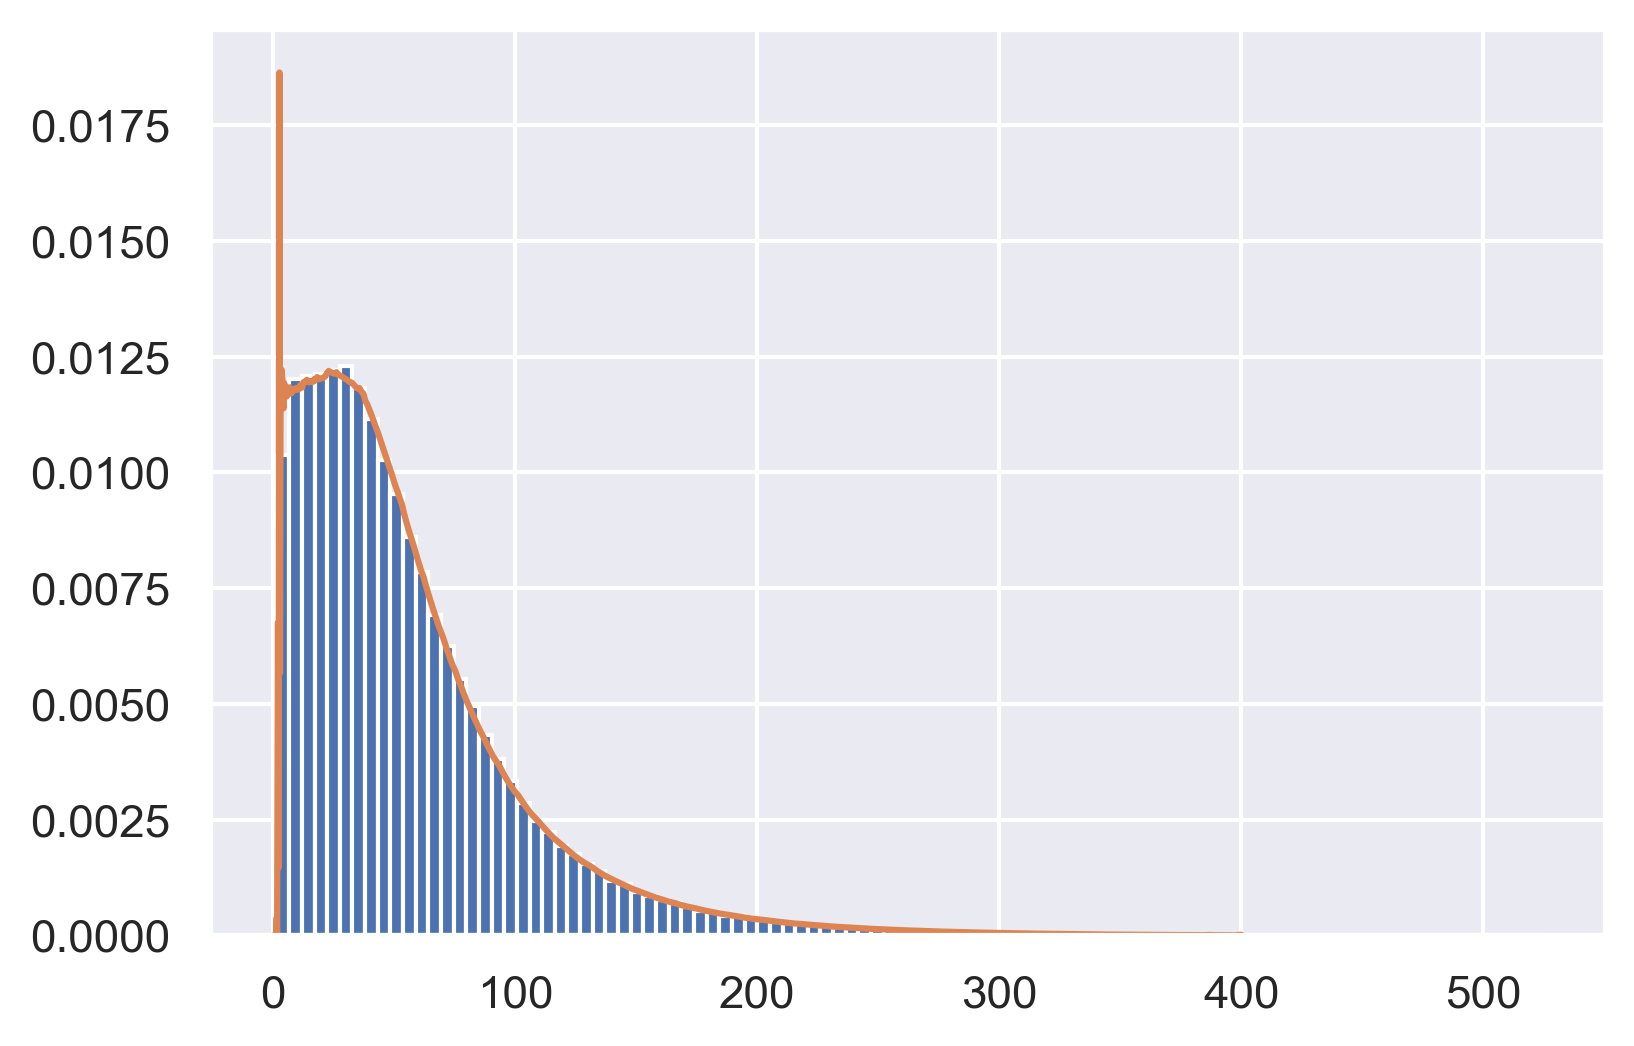

In [14]:
start = time.time()

K_nonstochastic = K

R = (α*K_nonstochastic**(α-1)+(1-δ))/(1-params.death_prob)
wage = (1-α)*K_nonstochastic**α

consumption_function, v = compute_optimal_consumption_function(initial_v, R, wage, params)

b_end_of_period = params.mgrid-consumption_function

Klist_old_method = []
distorted_probabilities = False

Ndraws = 100

for seed in range(Ndraws):
    m = 15.0
    P = 1.0
    Nperiods = int(1e6)
    
    mlist, Plist, blist = \
    simulate_agent_many_periods(m, P, consumption_function, Nperiods,
                                params,
                                R, wage,
                                distorted_probabilities, seed)
    
    Klist_old_method.append(np.mean(blist*Plist))
        
end = time.time()
print("*"*30)
print("Computation complete")
print("Total computation time:", end-start)

plt.hist(mlist, density = True, bins = 100, weights = Plist)
plt.plot(params.mgrid, piw_distribution/dmgrid)
plt.savefig("stochastic_simulation_piw.pdf")
plt.show()

******************************
Computation complete
Total computation time: 98.0776960849762


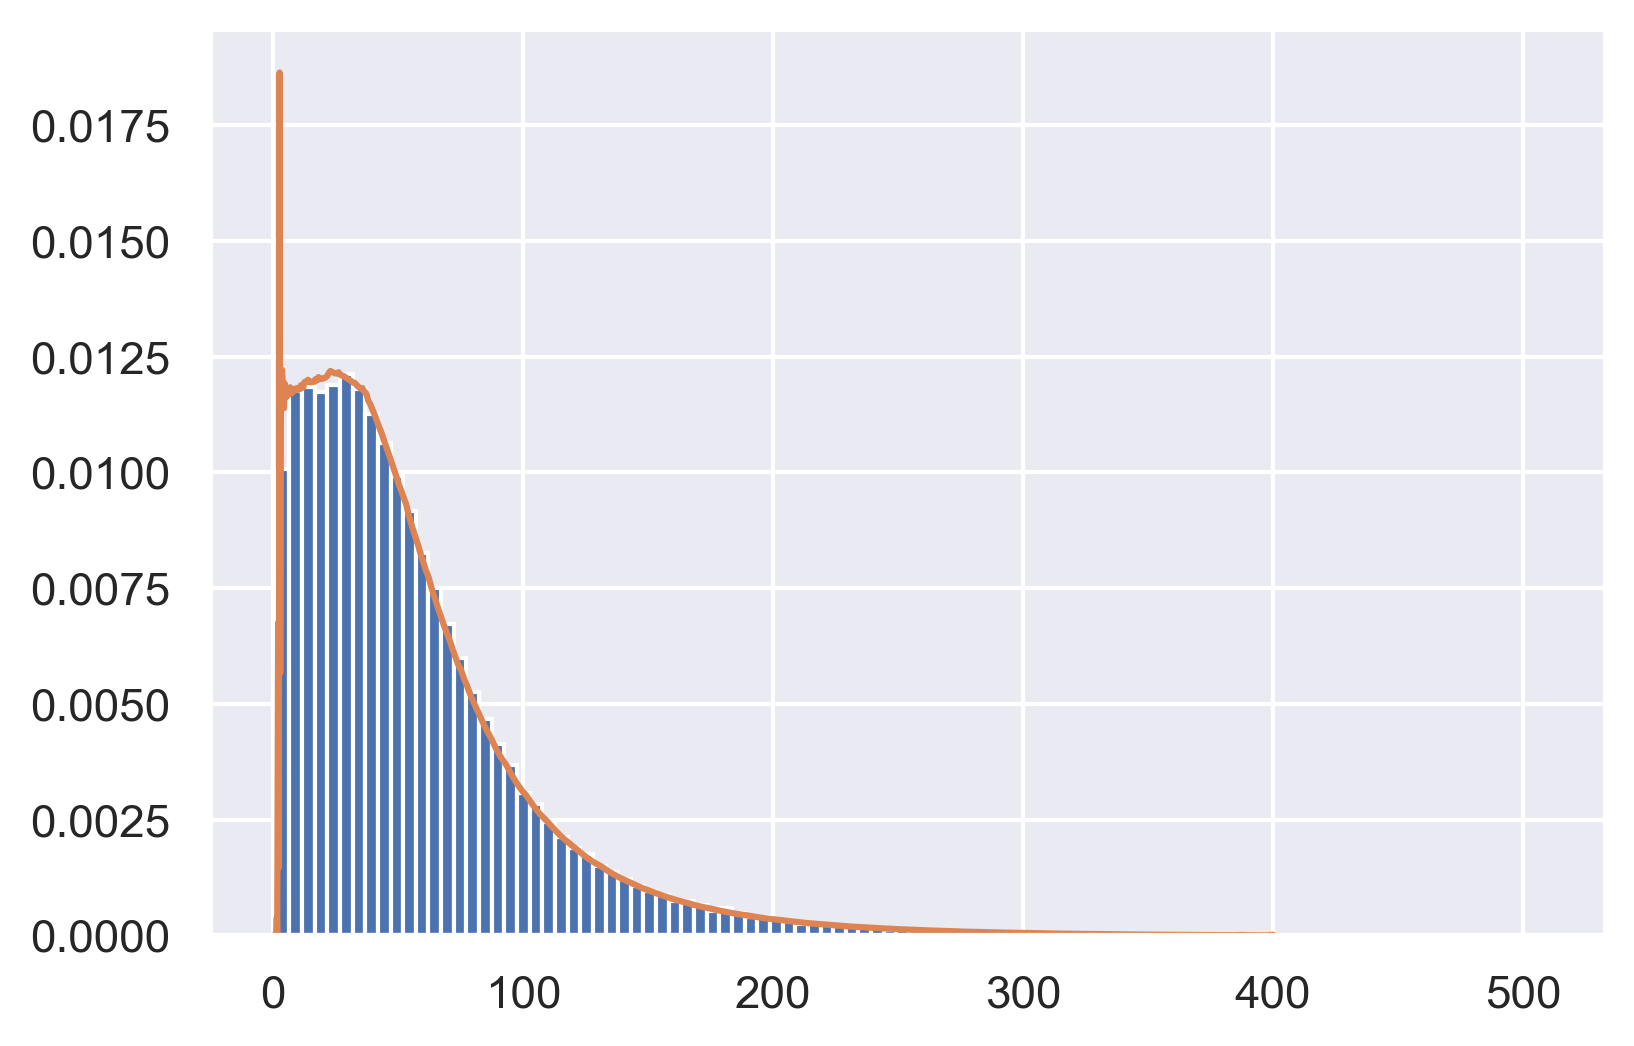

In [15]:
start = time.time()

Klist_new_method = []
distorted_probabilities = True

for seed in range(Ndraws):
    m = 15.0
    P = 1.0
    Nperiods = int(1e6)
    
    mlist, Plist, blist = \
    simulate_agent_many_periods(m, P, consumption_function, Nperiods,
                                params,
                                R, wage,
                                distorted_probabilities, seed)
    
    Klist_new_method.append(np.mean(blist*Plist))

end = time.time()
print("*"*30)
print("Computation complete")
print("Total computation time:", end-start)

plt.hist(mlist, density = True, bins = 100, weights = Plist)
plt.plot(params.mgrid, piw_distribution/dmgrid)
plt.show()

## Stochastic results for the paper

Below, I summarize the above

In [16]:
print("Comparison")
print("W/o PIN measure:", np.mean(Klist_old_method), np.std(Klist_old_method)/np.sqrt(Ndraws))
print("W/ PIN measure:", np.mean(Klist_new_method), np.std(Klist_new_method)/np.sqrt(Ndraws))
print(np.mean(Klist_old_method)/np.mean(Klist_new_method),
      np.std(Klist_old_method)/np.std(Klist_new_method))

Comparison
W/o PIN measure: 52.93853389671755 0.14961385356743498
W/ PIN measure: 52.851884405206626 0.06230294546254591
1.001639477806441 2.401392943089295


# Non-stochastic results for the paper

Below, I compute the non-stochastic results for the paper.

In [17]:
b_end_of_period = params.mgrid-consumption_function


start = time.time()
piw_distribution = compute_cash_on_hand_distribution(consumption_function, 
                                                     params, R, wage,
                                                     which = 'Permanent Income Weighted')
end = time.time()
print("*"*30)
print("With PIN measure")
print("Computation time:", end - start)
print("Savings:", np.sum(b_end_of_period*piw_distribution))

print("*"*30)
print("With 31 grid points")
start = time.time()
stationary_distribution_2d = compute_stationary_distribution_2d(consumption_function, \
                                                                params, R, wage)
end = time.time()
print("Computation time:", end - start)

zstate = np.vstack([params.zgrid for k in range(params.Nm)])
print("Savings:",
      np.sum(b_end_of_period*np.sum(stationary_distribution_2d*np.exp(zstate), axis = 1)))

print("*"*30)
print("With 101 grid points")

zgrid_new = np.linspace(-10, 10, 101)
params_new = problem_parameters(β, σ, mgrid, bgrid, zgrid_new,
                   Nepsilon, epsilon_val, epsilon_prob,
                   Neta, eta_val, eta_prob, death_prob)

start = time.time()
stationary_distribution_2d_new = compute_stationary_distribution_2d(consumption_function, \
                                                                    params_new, R, wage)
end = time.time()
print("Computation time:", end - start)
print("Savings:",
      np.sum(b_end_of_period*np.sum(stationary_distribution_2d_new*np.exp(zstate_new), axis = 1)))

******************************
With PIN measure
Computation time: 0.010415792465209961
Savings: 53.11962036402264
******************************
With 31 grid points
Computation time: 1.1111879348754883
Savings: 50.864529936550596
******************************
With 101 grid points
Computation time: 11.582109212875366
Savings: 53.108711064931825


Figure for the paper:

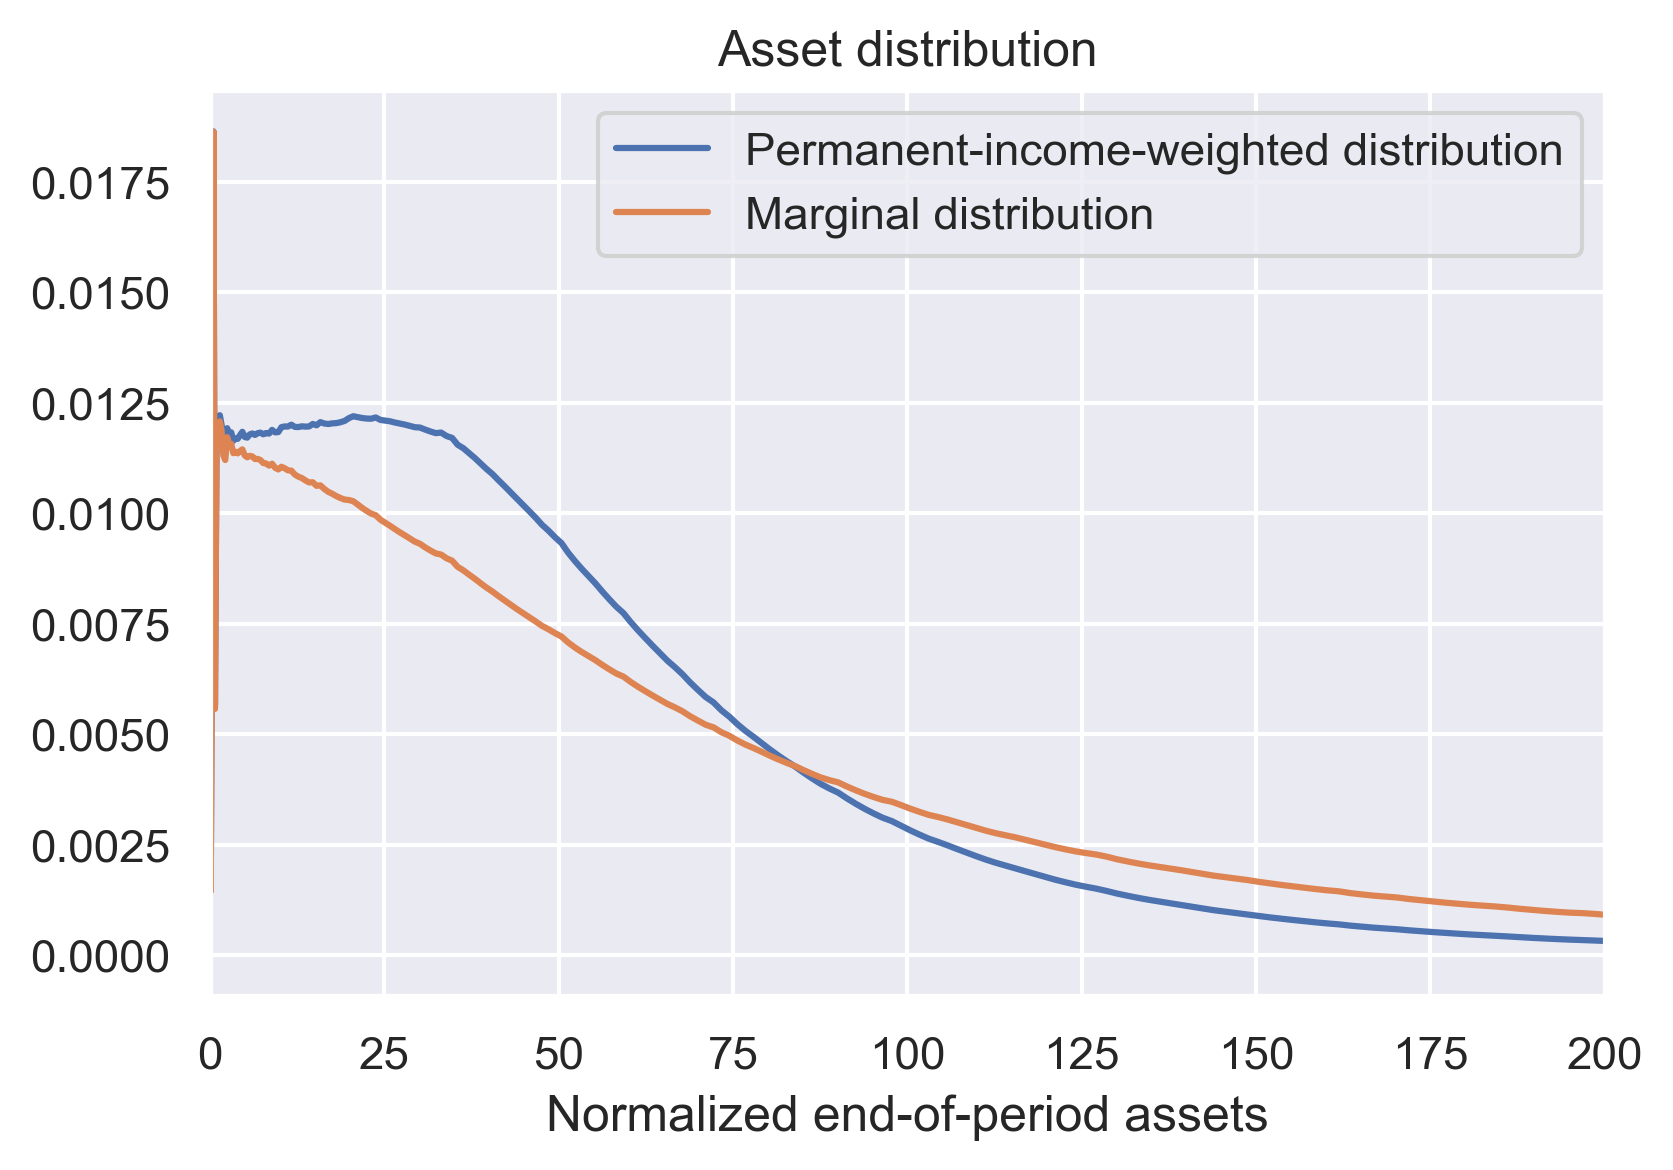

In [18]:
piw_distribution = compute_cash_on_hand_distribution(consumption_function, 
                                                     params, R, wage,
                                                     which = 'Permanent Income Weighted')
marginal_distribution = compute_cash_on_hand_distribution(consumption_function, 
                                                     params, R, wage,
                                                     which = 'Marginal')

plt.plot(params.mgrid-consumption_function, piw_distribution/dmgrid, 
         label = 'Permanent-income-weighted distribution')
plt.plot(params.mgrid-consumption_function, marginal_distribution/dmgrid, 
         label = 'Marginal distribution')
plt.legend()
plt.xlabel('Normalized end-of-period assets')
plt.xlim([0, 200])
plt.title('Asset distribution')
plt.savefig('histogram.pdf')
plt.show()

Finally, we display the equilibrium consumption function:

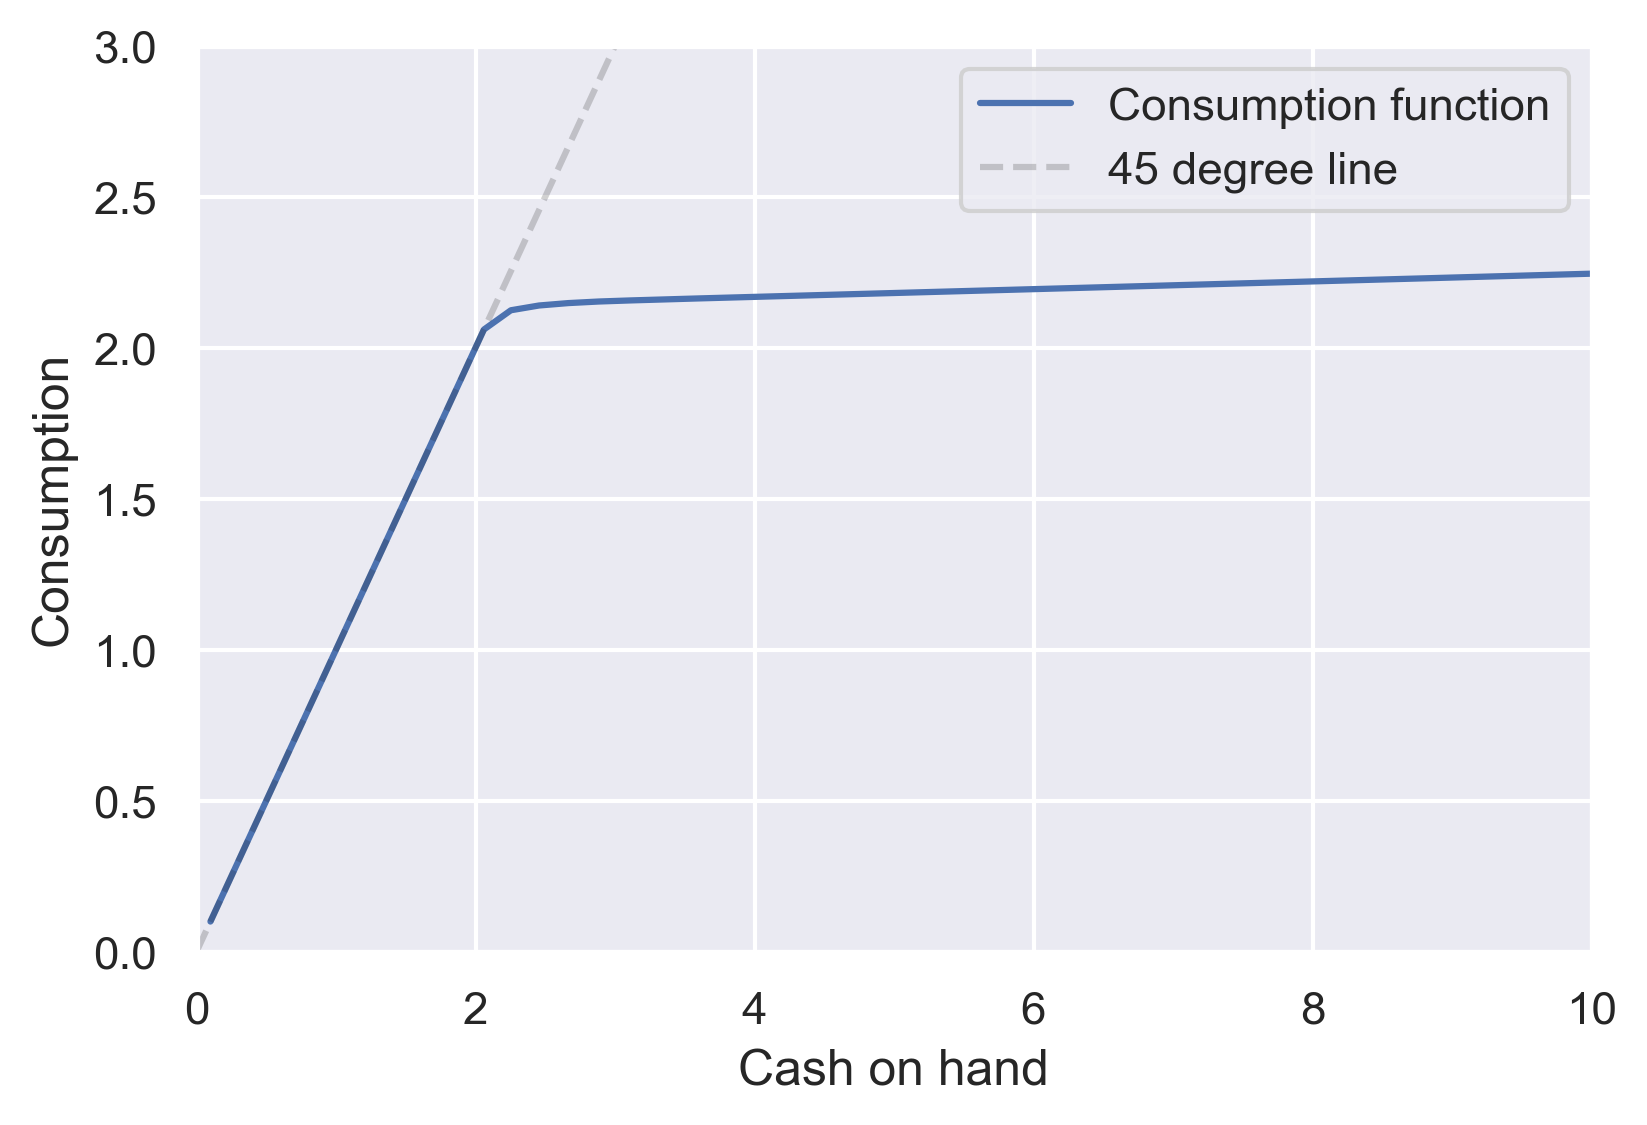

In [19]:
plt.plot(params.mgrid, consumption_function, label = 'Consumption function')
plt.plot([0, 5], [0, 5], '--', color = 'k', alpha = 0.2, label = '45 degree line')
plt.xlim([0, 10])
plt.xlabel('Cash on hand')
plt.ylabel('Consumption')
plt.legend()
plt.ylim([0, 3])
plt.savefig('consumption_function.pdf')
